# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [15]:
import pandas as pd
import numpy as np
import math

## Загрузка и предобработка данных

Загрузим данные и проведем предобраотку данных как на семинаре.

In [16]:
!wget -q -N https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0 -O articles.zip
!unzip -o -q articles.zip

In [17]:
!unzip -o -q articles.zip

In [136]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [19]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [137]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [21]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [22]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [23]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [24]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглажиываем полученный результат, взяв от него логарифм.

In [25]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [26]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [27]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [28]:
!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Задание 1. (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [80]:
# Хотел делать разреженную матрицу так, как учили год назад на Введении в анализ данных, но решил пойти проверенным путём и использовать код с семинара
data = pd.pivot_table(
    interactions_full_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)
data_train = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)
data_test = pd.pivot_table(
    interactions_test_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [81]:
data.shape

(1140, 2984)

In [185]:
data.columns

Index(['-1006791494035379303', '-1021685224930603833', '-1022885988494278200',
       '-1024046541613287684', '-1033806831489252007', '-1038011342017850',
       '-1039912738963181810', '-1046621686880462790', '-1051830303851697653',
       '-1055630159212837930',
       ...
       '9222265156747237864', '943818026930898372', '957332268361319692',
       '962287586799267519', '966067567430037498', '967143806332397325',
       '972258375127367383', '980458131533897249', '98528655405030624',
       '991271693336573226'],
      dtype='object', name='contentId', length=2984)

In [83]:
#Сделать пустую матрицу размерности всех возможных взаимодействий
# Заполнить на основании Pivot data_train
from scipy.sparse import csr_matrix 
data_train  = csr_matrix(data_train.mul(data, fill_value=0).apply(np.sqrt))
data_test  = csr_matrix(data_test.mul(data, fill_value=0).apply(np.sqrt))

In [84]:
data_train

<1140x2984 sparse matrix of type '<class 'numpy.float64'>'
	with 29329 stored elements in Compressed Sparse Row format>

In [85]:
data_test

<1140x2984 sparse matrix of type '<class 'numpy.float64'>'
	with 9777 stored elements in Compressed Sparse Row format>

## Задание 2. (1 балл)

Обучите модель LightFM с `loss='warp'` и посчитайте *precision@10* на тесте.

In [98]:
LFM = LightFM(loss='warp', k=10)
LFM.fit(data_train)

In [99]:
from lightfm.evaluation import precision_at_k
precision_at_k(LFM, data_test, k=10).mean()

0.003971487

Видим, что качество прогнозов рекомендательной системе находится на крайне низком уровне. Попытавшись поиграть с параметрами регуляризации и методами обучения, качество увеличить, к сожалению, так и не удалось. Посмотрим, что выдаёт нам модель на обучающей выборке:

In [100]:
precision_at_k(LFM, data_train, k=10).mean()

0.1227518

Кажется, что либо k=10 - слишком большое значение, либо модель сильно недообучилась, либо данные просто плохие

## Задание 3. (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss='warp'` и посчитайте precision@10 на тесте.

In [103]:
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


Я решил допустимым немножко считерить и взять собственный код из домашки по мо-2 для наиболее качественной обработки текста статей

In [138]:
articles_df = articles_df[articles_df['contentId'].isin(interactions_full_df['contentId'])]

In [135]:
interactions_full_df[interactions_full_df['contentId'].isin(articles_df['contentId'])]['contentId'].unique().shape

(2976,)

In [188]:
pre_feat = pd.DataFrame(interactions_full_df['contentId'].unique(), columns=['contentId'])
pre_feat = pre_feat.merge(articles_df, how='left')

In [189]:
pre_feat = pre_feat.set_index('contentId')
pre_feat = pre_feat.reindex(index=data.columns)
pre_feat = pre_feat.reset_index()

In [190]:
pre_feat.shape

(2984, 13)

In [121]:
# Ваш код здесь
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [105]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [106]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [170]:
pre_feat['raw_text'].isnull().sum()

8

In [191]:
pre_feat['raw_text'] = pre_feat.apply(lambda row: row.title + row.text, axis=1)
pre_feat['raw_text'] = pre_feat['raw_text'].fillna('Null')
pre_feat['preprocessed_text'] = pre_feat.apply(lambda row: preprocess(row.raw_text), axis=1)

In [108]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

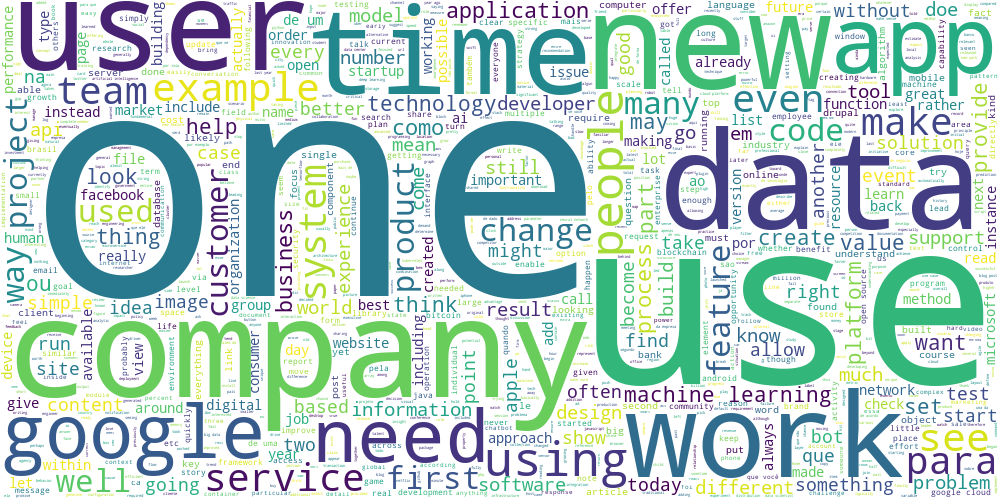

In [192]:
draw_wordcloud(pre_feat.preprocessed_text)

Вообще, возможно следовало бы покластеризовать статьи по нашим получившимся эмбеддингам, после чего использовать номера кластеров в качестве достаточно сильных признаков (в рамках кластеров могли бы найти фанатов и хейтеров того или иного типа статей).

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
feat = vectorizer.fit_transform(pre_feat['preprocessed_text'])

In [194]:
feat.shape

(2984, 63998)

In [195]:
data_train.shape

(1140, 2984)

Теперь наконец мы можем обучить нашу модель для рекомендаций:

In [196]:
LFM.fit(data_train, item_features=feat)

In [197]:
precision_at_k(LFM, data_test, item_features=feat, k=10).mean()

0.00407332

0.00397 -> 0.00407 => уже хоть какой-то прогресс, ура? Посмотрим, как там обстоят дела на обучающей выборке. Может быть недообучение пропало?

In [198]:
precision_at_k(LFM, data_train, item_features=feat, k=10).mean()

0.1467626

Качество увеличилось на 2%, вполне нормальный буст, но тем не менее при добавлении 64 тысяч новых признаков, описывающих айтемы, хотелось бы ожидать чуть более кардинальное увеличение.

## Задание 4. (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [ ]:
# Ваш код здесь

Ой, а я уже сделал это в прошлом задании. Ну давайте я покажу здесь что было бы без предварительной предобработки данных. То есть по сути мы должны просто взять столбец "Raw_text" вместо "preprocessed".

In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
feat = vectorizer.fit_transform(pre_feat['raw_text'])

In [200]:
LFM.fit(data_train, item_features=feat)

In [201]:
precision_at_k(LFM, data_test, item_features=feat, k=10).mean()

0.005397149

Улучшилось ли качество предсказания?

Так, я сейчас вообще не понял что произошло, но почему-то сырой текст выдаёт более высокое качество, чем обработанный. Странно, но видимо стоп-слова и большие буквы помогают лучше рекомендовать статьи...

## Задание 5. (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

Для подбора гиперпараметров воспользуемся кодом вот отсюда:
https://stackoverflow.com/questions/49896816/how-do-i-optimize-the-hyperparameters-of-lightfm

In [232]:
import itertools
from lightfm.evaluation import precision_at_k

def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(k=10, **hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = precision_at_k(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [234]:
(score, hyperparams, model) = max(random_search(data_train, data_test, num_samples=100, num_threads=4), key=lambda x: x[0])
print("Best score {} at {}".format(score, hyperparams))

Best score 0.008350306190550327 at {'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.02721143074651593, 'item_alpha': 7.063131466326624e-09, 'user_alpha': 5.787499804560056e-09, 'max_sampled': 5, 'num_epochs': 45}


In [238]:
LFM = LightFM(no_components=57, 
              learning_schedule='adagrad',
              loss='warp',
              learning_rate=0.03,
              item_alpha=7e-09,
              user_alpha=6e-09,
              max_sampled=5,  
              k=10)

In [244]:
LFM.fit(data_train, epochs=45)

In [245]:
precision_at_k(LFM, data_test, k=10).mean()

0.004378819

В результате случайного подбора гиперпараметров точность на данных о взамиодействиях без учёта фичей айтемов увеличилась лишь незначительно. Попробуем взять те же гиперпараметры для модели, учитывающей эмбеддинги статей.

In [242]:
LFM.fit(data_train, epochs=10, item_features=feat)

In [243]:
precision_at_k(LFM, data_test, item_features=feat, k=10).mean()

0.0054989816

Видим, что точность увеличилась на 0.0001 относительно предыдущей лучшей модели. С учётом специфики задания не так уж и плохо, как мне кажется.

## Бонусное задание. (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [ ]:
# Ваш код здесь